In [14]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Parameters for data generation following Roth paper
n = 6000
x_std = 0.1
y_std = 0.25
d = 15 # choose d > 10

# std_dev_list = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])
std_dev_list = np.array([2.0, 0.1, 5.0, 0.1, 0.1, 10.0, 0.1, 1.0, 4.0, 0.1]) 

theta = np.random.normal(loc=np.zeros(d), scale=x_std)

In [16]:
from group import compute_group_coverages, compute_split_coverages

# group definition
# each binary attribute defines membership in a group 
# x = 0011
# x belongs to groups 0, 2, 5, 7
# x = 0110
# x belongs to groups 0, 3, 5, 6

def get_groups(x):
    """
    Returns binary membership vectors for groups
    
    expects x to be a binary matrix of dimension (N, p)
    returns a membership matrix of dimension (N, 2 * p)
    """
    group_ids = np.zeros((x.shape[0], x.shape[1] * 2))
    for row in range(x.shape[0]):
        for i, x_val in enumerate(x[row,:]):
            group_ids[row, int(2 * i + x_val)] = 1
    return group_ids

def generate_synthetic_data(n, x_std, y_std, d, std_dev_list, theta):
    # d-dimension features - first 10 features are binary
    xs_binvars = np.random.randint(low = 0, high = 2, size = (n, 10))
    xs_remvars = np.random.normal(loc=np.zeros(d - 10), scale=x_std, size=(n, d - 10))
    xs = np.concatenate((xs_binvars, xs_remvars), axis = 1)

    std_dev = np.dot(xs_binvars, std_dev_list) + y_std
    ys = np.dot(xs, theta) + np.random.normal(loc=0, scale= std_dev, size=n)
    # Separate training data into training (for point-predictor) and calibration

    x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.5, random_state=42)

    calibration_set_size = math.floor(0.25*n)
    train_set_size = len(y_train) - calibration_set_size
    x_train_final = x_train[ : train_set_size]
    x_calib = x_train[train_set_size : ]
    y_train_final = y_train[ : train_set_size]
    y_calib = y_train[train_set_size : ]
    
    return x_train_final, y_train_final, x_calib, y_calib, x_test, y_test



In [17]:
def run_synthetic_trial(n, x_std, y_std, d, std_dev_list, theta, n_test, alpha):
    x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_synthetic_data(
        n, x_std, y_std, d, std_dev_list, theta
    )

    reg = LinearRegression().fit(x_train_final, y_train_final)

    scores_calib = np.abs(reg.predict(x_calib) - y_calib)
    group_calib = get_groups(x_calib[:,0:10])

    scores_test = np.abs(reg.predict(x_test[0:n_test]) - y_test[0:n_test])
    groups_test = get_groups(x_test[0:n_test,0:10])

    adaptive_coverages = compute_group_coverages(
        group_calib, scores_calib, scores_test, groups_test, groups_test[0:n_test], alpha
    )

    split_coverages = compute_split_coverages(
       scores_calib, scores_test, groups_test, alpha
    )

    adapt_cover = pd.Series(adaptive_coverages)
    split_cover = pd.Series(split_coverages)

    df = pd.concat([adapt_cover, split_cover], keys=["adaptive", "split"], axis=1).reset_index()
    return df

In [19]:
df = pd.DataFrame()
n_test = 100
alpha = 0.7
for i in range(5):
    append_df = run_synthetic_trial(n, x_std, y_std, d, std_dev_list, theta, n_test=n_test, alpha=alpha)
    append_df['trial'] = i
    df = pd.concat([df, append_df])


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 27.24it/s]


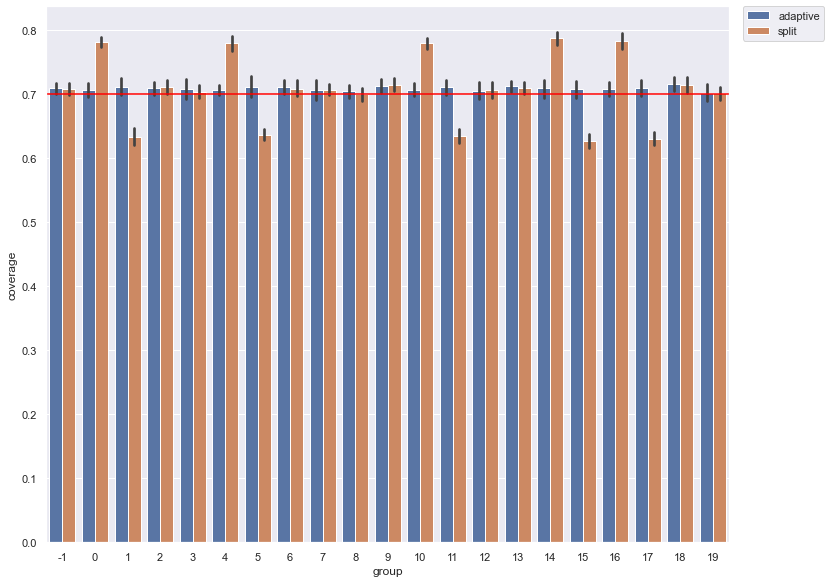

In [8]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

melted_df = pd.melt(df, id_vars=["index"], value_vars=["adaptive", "split"])
melted_df = melted_df.rename(columns={"index": "group", "value": "coverage"})

fig = sns.barplot(melted_df, 
            x="group", y="coverage", hue="variable")
fig.axhline(0.7, color='red')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

In [21]:
fig.get_figure().savefig('synthetic_group_coverage.png')

In [37]:
# test full conformal

from group import compute_threshold, setup_cvx_problem

x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_synthetic_data(
    n, x_std, y_std, d, std_dev_list, theta
)

reg = LinearRegression().fit(x_train_final, y_train_final)

scores_calib = np.abs(reg.predict(x_calib) - y_calib)
group_calib = get_groups(x_calib[:,0:10])

scores_test = np.abs(reg.predict(x_test[0:n_test]) - y_test[0:n_test])
groups_test = get_groups(x_test[0:n_test,0:10])

prob = setup_cvx_problem(group_calib, scores_calib, alpha)

In [38]:
threshold_max = compute_threshold(prob, groups_test[2,:], scores_calib, M = None)
threshold_full = compute_threshold(prob, groups_test[2,:], scores_calib, M = 'full')
threshold_min = compute_threshold(prob, groups_test[2,:], scores_calib, M = 0)

print(threshold_max, threshold_full, threshold_min)

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 30.20it/s]

16.113497055912237 15.601788468296405 15.966099305361475
